In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm_notebook, tnrange
from itertools import chain
#from skimage.io import imread, imshow, concatenate_images
#from skimage.transform import resize
#from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd 
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cutstrainpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\train\\cuts\\'
maskstrainpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\train\\masks\\'

cutsvalidpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\valid\\cuts\\'
masksvalidpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\valid\\masks\\'

cutstestpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\test\\cuts\\'
maskstestpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\test\\masks\\'


im_width = 80
im_height = 80
imgsize = 80

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
def load_cuts(pathname):
    X_train = []
    
    for f in os.listdir(pathname):
        if f.endswith('.png'):
            img = np.zeros([imgsize,imgsize,3],dtype=np.uint8)
            img = cv2.imread(os.path.join(pathname, f),1)
            
            assert img.shape == (imgsize, imgsize, 3)

            X_train.append(img)
        
    return X_train

def load_masks(pathname):
    y_train = []
    imgblue = [[[0 for x in range(imgsize)] for y in range(imgsize)]  for z in range(3)]
  
    for f in os.listdir(pathname):
        if f.endswith('.png'):
            #print(os.path.join(pathname, f))
            #img_blue = [[[0 for x in range(imgsize)] for y in range(imgsize)]  for z in range(3)]
            img_blue = np.zeros([imgsize,imgsize,3],dtype=np.uint8)
            
            img = cv2.imread(os.path.join(pathname, f),1)
            
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            assert img_gray.shape == (imgsize, imgsize)

            img_blue[:,:,2] = img_gray
            
            y_train.append(img_blue)
     
    return y_train

In [ ]:
X_train=[]
y_train=[]
cuts_valid=[]
masks_valid=[]


X_train = load_cuts(cutstrainpath)
print(len(X_train))
y_train = load_masks(maskstrainpath)
print(len(y_train))
cuts_valid = load_cuts(cutsvalidpath)
print(len(cuts_valid))
masks_valid = load_masks(masksvalidpath)
print(len(masks_valid))



In [112]:
def showcuts(datalist, lastpics=10):

    assert lastpics <= len(datalist)

    orgtail = datalist[len(datalist)-lastpics:]

    columns = 5
    rows = lastpics//columns
    fig=plt.figure(figsize=(15, 2*rows))
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(orgtail[i])
        

In [ ]:
showcuts(X_train, 6)
showcuts(y_train, 6)
#plt.imshow(X_train[0])
#plt.imshow(y_train[0], cmap=plt.get_cmap('gray'))

In [114]:
X_train = np.array(X_train, dtype=np.float32)
y_train= np.array(y_train, dtype=np.float32)
cuts_valid = np.array(cuts_valid, dtype=np.float32)
masks_valid = np.array(masks_valid, dtype=np.float32)

X_train -= X_train.mean()
X_train /= X_train.std()
cuts_valid -= cuts_valid.mean()
cuts_valid /= cuts_valid.std()

y_train //= 255
masks_valid //= 255

In [118]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

#model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 80, 80, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 80, 80, 16)   64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 80, 80, 16)   0           batch_normalization_73[0][0]     
____________________________________________________________________________________________

In [119]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ct-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [120]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks, validation_data=(cuts_valid, masks_valid))

Train on 9539 samples, validate on 1590 samples
Epoch 1/10
9539/9539 [==============================] - 18s 2ms/step - loss: 0.3849 - accuracy: 0.9906 - val_loss: 0.3832 - val_accuracy: 0.9949

Epoch 00001: val_loss improved from inf to 0.38319, saving model to model-ct-1.h5
Epoch 2/10
9539/9539 [==============================] - 15s 2ms/step - loss: 0.3820 - accuracy: 0.9945 - val_loss: 0.3830 - val_accuracy: 0.9926

Epoch 00002: val_loss improved from 0.38319 to 0.38297, saving model to model-ct-1.h5
Epoch 3/10
9539/9539 [==============================] - 15s 2ms/step - loss: 0.3815 - accuracy: 0.9949 - val_loss: 0.3818 - val_accuracy: 0.9951

Epoch 00003: val_loss improved from 0.38297 to 0.38177, saving model to model-ct-1.h5
Epoch 4/10
9539/9539 [==============================] - 15s 2ms/step - loss: 0.3811 - accuracy: 0.9952 - val_loss: 0.3819 - val_accuracy: 0.9946

Epoch 00004: val_loss did not improve from 0.38177
Epoch 5/10
9539/9539 [==============================] - 15s 2ms

In [178]:
X_test = load_cuts(cutstestpath)
print(len(X_test))
y_test = load_masks(maskstestpath)
print(len(y_test))

318
318


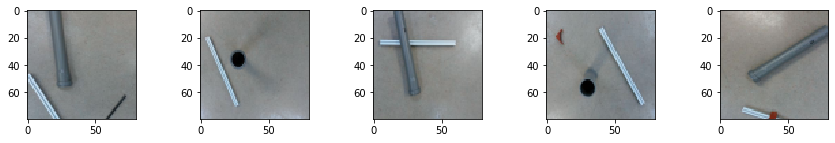

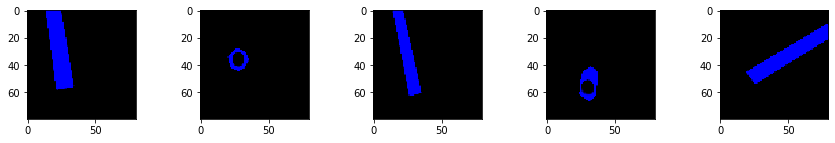

In [179]:
X_pics=X_test.copy()
y_pics=y_test.copy()


showcuts(X_pics, 6)
showcuts(y_pics, 6)

In [180]:
X_test = np.array(X_test, dtype=np.float32)
cuts_valid = np.array(cuts_valid, dtype=np.float32)

X_test -= X_test.mean()
X_test /= X_test.std()

In [181]:
predictions_test = model.predict(X_test, batch_size=32, verbose=1)

318/318 [==============================] - 0s 560us/step


In [182]:
def predictedmask(piclist, thresh=0.6):
    y_list = []
    for pic in piclist:
        assert pic.shape == (imgsize, imgsize, 3)
        imgret = np.zeros((imgsize, imgsize,3), np.uint8)
        for i in range(imgsize):
            for j in range(imgsize):
                imgret[i,j,0] = 0
                imgret[i,j,1] = 0
                if pic[i,j,2] >= thresh:
                    imgret[i,j,2] = 255
                else:
                    imgret[i,j,2] = 0


        y_list.append(imgret)
    return y_list

In [183]:
predictions_pics = predictedmask(predictions_test,0.5)

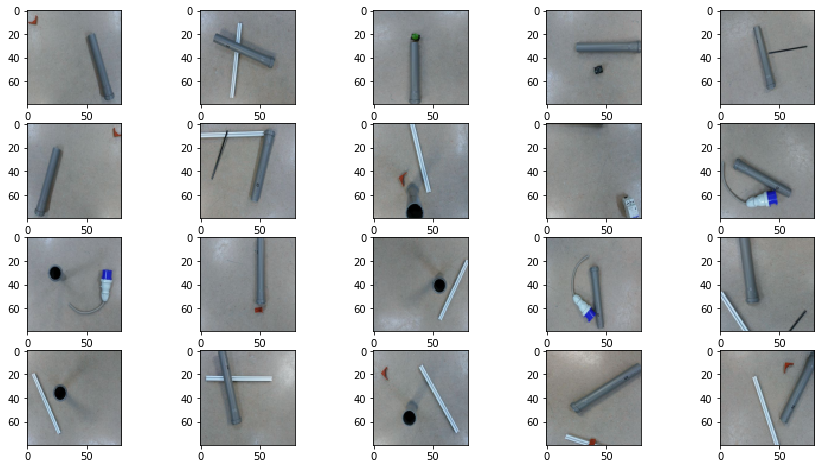

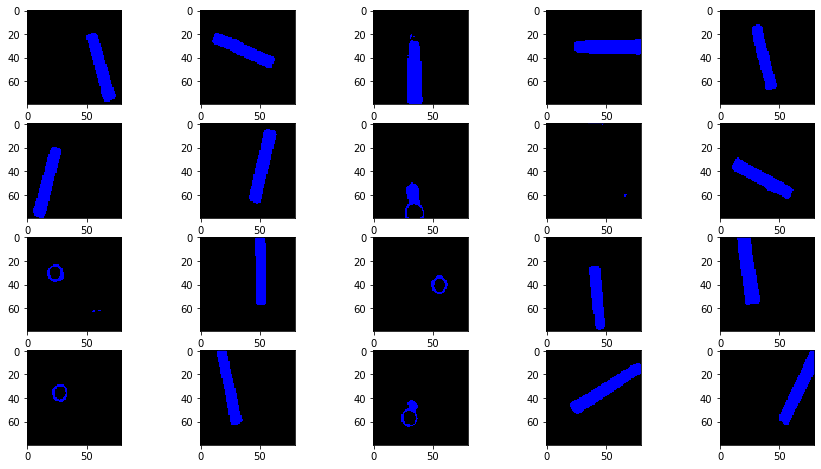

In [185]:
showcuts(X_pics, 20)
showcuts(predictions_pics, 20)

In [186]:
model_json = model.to_json()
with open("modeltrained.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modeltrained.h5")


In [ ]:
json_file = open('modeltrained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modeltrained.h5")
print("Loaded model from disk")

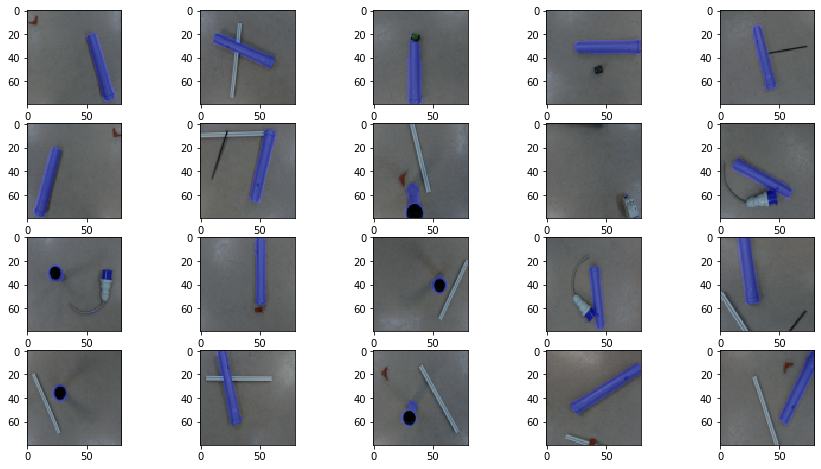

In [188]:
imglist=[]
for c,m in zip(X_pics, predictions_pics):
    imglist.append(cv2.addWeighted(c, 0.7, m, 0.3, 0))
    
showcuts(imglist, 20)